# ERA5

In [1]:
import os
from pathlib import Path

import dask
from dask.distributed import LocalCluster, Client
import dask_jobqueue
from fsspec.implementations.reference import ReferenceFileSystem
import pytcube
import xarray as xr

## Cluster

In [3]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:48764")
client

<Client: 'tcp://127.0.0.1:48764' processes=7 threads=28, memory=115.00 GiB>

## DataCube

In [4]:
fs = ReferenceFileSystem(
    "/home/datawork-data-terra/odatis/data/era5/datacube.parq",
    target_protocol="file",
    lazy=True,
)
datacube = xr.open_dataset(
    fs.get_mapper(), engine="zarr", backend_kwargs={"consolidated": False}, chunks=None
)
datacube = datacube.rename({'longitude025':'lon', 'latitude025':'lat'})
datacube = datacube[['u10', 'v10']]
datacube['lon'] = datacube.coords['lon'] = (datacube.coords['lon'] - 180) % 360 - 180
datacube = datacube.sortby('lon')
datacube

<xarray.Dataset> Size: 3TB
Dimensions:  (time: 396672, lat: 721, lon: 1440)
Coordinates:
  * lat      (lat) float32 3kB -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
  * time     (time) datetime64[ns] 3MB 1979-04-01 ... 2024-06-30T23:00:00
  * lon      (lon) float32 6kB -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
Data variables:
    u10      (time, lat, lon) float32 2TB ...
    v10      (time, lat, lon) float32 2TB ...
Attributes:
    Conventions:  CF-1.6
    History:      Downloaded from copernicus ; format updated at Ifremer

## Dataset

In [5]:
dataset = xr.open_dataset('/home/datawork-cersat-public/cache/users/jfpiolle/felyx/mdb/swot/2023/20231119000000_SWOT_L3_LR_SSH_Unsmoothed__cmems_drifter.nc')
dataset = dataset[['time', 'lon', 'lat']]
dataset = dataset.assign_coords({'obs': dataset.obs})
dataset

<xarray.Dataset> Size: 5kB
Dimensions:  (obs: 146)
Coordinates:
    time     (obs) datetime64[ns] 1kB ...
    lon      (obs) float64 1kB ...
    lat      (obs) float64 1kB ...
  * obs      (obs) int64 1kB 0 1 2 3 4 5 6 7 ... 138 139 140 141 142 143 144 145
Data variables:
    *empty*
Attributes: (12/64)
    __id:                                 SWOT_L3_LR_SSH_Unsmoothed__cmems_dr...
    __time_coverage_end:                  2023-11-20T00:00:00
    __time_coverage_start:                2023-11-19T00:00:00
    swot_Conventions:                     CF-1.7
    swot_Metadata_Conventions:            Unidata Dataset Discovery v1.0
    swot___acknowledgement:               
    ...                                   ...
    swot_standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Me...
    swot_time_coverage_begin:             2023-11-19T10:02:11Z
    swot_time_coverage_end:               2023-11-19T10:52:56Z
    swot_time_coverage_resolution:        P1S
    swot_time_coverage_start:             2023-11-19T10:02:11Z
    swot_title:                           NRT SWOT KaRIn & nadir Global Ocean...

## Extraction

In [6]:
buffer = {'time': 21600, 'lon': 100, 'lat': 100}
n_obs_per_batch = 1_000
path = Path('/home1/scratch/gcaer/data/pytcube/era5.zarr')
optimize = False
chunk = {'time':1, 'lon':-1, 'lat': -1}

In [7]:
%%time
batches = pytcube.extraction(
    datacube=datacube, 
    dataset=dataset, 
    buffer=buffer, 
    n_obs_per_batch=n_obs_per_batch, 
    path=path, 
    optimize=optimize, 
    chunk=chunk
)

2025-01-17 16:09:28,562|INFO    |Formatting of the datacube                                                                          |datacube.py:28@_format()
2025-01-17 16:09:28,563|INFO    |Formatting of the dataset                                                                           |dataset.py:34@_format()
2025-01-17 16:09:28,565|INFO    |Calculation of buffer indices                                                                       |datacube.py:42@get_ibuffer()
2025-01-17 16:09:28,569|INFO    |Setup of the DataCube and the Dataset                                                               |processing.py:44@setup()
2025-01-17 16:09:28,588|INFO    |Processing of observations and creation of batches                                                  |processing.py:190@processing()


CPU times: user 88 ms, sys: 32 ms, total: 120 ms
Wall time: 161 ms


## Compute

In [8]:
n_batches_per_block = -1

In [9]:
%%time
results = pytcube.compute(
    batches=batches, 
    n_batches_per_block=n_batches_per_block
)

2025-01-17 16:09:32,439|INFO    |Start of computation                                                                                |api.py:110@compute()
2025-01-17 16:09:32,440|INFO    |Computation of the block 1/1 with 1 batches                                                         |api.py:116@compute()


CPU times: user 44 ms, sys: 4 ms, total: 48 ms
Wall time: 29 s


## Results

In [10]:
result = xr.open_zarr(path)
result = result.swap_dims({"id": "obs"})
result = result.sortby('obs')
result

<xarray.Dataset> Size: 69MB
Dimensions:        (obs: 146, y: 9, x: 9, t: 721)
Coordinates:
    datacube_lat   (obs, y) float64 11kB dask.array<chunksize=(146, 9), meta=np.ndarray>
    datacube_lon   (obs, x) float64 11kB dask.array<chunksize=(146, 9), meta=np.ndarray>
    datacube_time  (obs, t) datetime64[ns] 842kB dask.array<chunksize=(146, 721), meta=np.ndarray>
    dataset_lat    (obs) float64 1kB dask.array<chunksize=(146,), meta=np.ndarray>
    dataset_lon    (obs) float64 1kB dask.array<chunksize=(146,), meta=np.ndarray>
    dataset_time   (obs) datetime64[ns] 1kB dask.array<chunksize=(146,), meta=np.ndarray>
    id             (obs) int64 1kB 46 13 14 97 127 15 128 ... 69 66 9 96 125 126
  * obs            (obs) int64 1kB 0 1 2 3 4 5 6 ... 139 140 141 142 143 144 145
Dimensions without coordinates: y, x, t
Data variables:
    datacube_u10   (obs, t, x, y) float32 34MB dask.array<chunksize=(146, 414, 9, 9), meta=np.ndarray>
    datacube_v10   (obs, t, x, y) float32 34MB dask.array<chunksize=(146, 414, 9, 9), meta=np.ndarray>

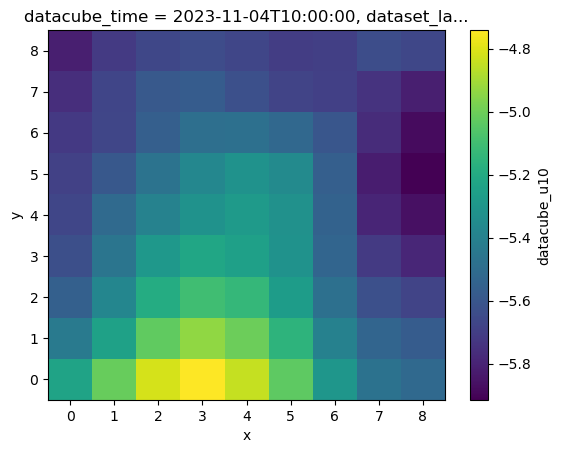

In [11]:
result.isel(obs=0, t=0).datacube_u10.plot(x='x', y='y', cmap='viridis')